# Benefit of Updating

Here we look at the FPR of models trained when there is a feedback loop, and without a feedback loop. We look at different types of model and different types of data. We want to show that there is a benefit when we are updating without feedback since otherwise the best thing to do would be keep our model static. I.e. we want to highlight the paradox that exists:

1. No feedback --> we want to update our model as often as possible to get better performance from larger sample size
2. Feedback --> want to keep model static/update less often to prevent runaway FPR

In [18]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model
import sklearn.naive_bayes as naive_bayes
import sklearn.svm as svm

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification, make_gaussian_quantiles, make_moons
from sklearn.model_selection import train_test_split

import importlib
import utils
importlib.reload(utils)

from utils import eval_model, perturb_labels_fp, update_model_feedback, update_model_no_feedback, make_gaussian_data, update_model_full_fit

%matplotlib inline

In [ ]:
def generate_gaussian_data(m0, m1, s0, s1, p0, p1, num_features=2):
    def wrapped(n_train, n_update, n_test):
        x_train, y_train = make_gaussian_data(m0, m1, s0, s1, n_train, p0, p1, features=num_features)

        x_update, y_update = make_gaussian_data(m0, m1, s0, s1, n_update, p0, p1, features=num_features)
        x_test, y_test = make_gaussian_data(m0, m1, s0, s1, n_test, p0, p1, features=num_features)
        
        return x_train, y_train, x_update, y_update, x_test, y_test
    
    return wrapped

In [ ]:
def generate_sklearn_make_classification_data(n_train, n_update, n_test, num_features=2):
    x, y = make_classification(n_train + n_update + n_test, n_informative=num_features, n_features=num_features, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_update + n_test)
    x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)
    
    return x_train, y_train, x_update, y_update, x_test, y_test

In [ ]:
def generate_moons_data(n_train, n_update, n_test, num_features=2):
    x, y = make_moons(n_train + n_update + n_test)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_update + n_test)
    x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)
    
    return x_train, y_train, x_update, y_update, x_test, y_test

In [ ]:
def train_update_loop(n_train, n_update, n_test, num_updates, data_fn, model_fn, seeds):
    seeds = np.arange(10)
    initial_fprs = []
    updated_fprs = []

    for seed in seeds:
        np.random.seed(seed)

        x_train, y_train = make_gaussian_data(m0, m1, s0, s1, n_train, p0, p1, features=n_features)

        x_update, y_update = make_gaussian_data(m0, m1, s0, s1, n_update, p0, p1, features=n_features)
        x_test, y_test = make_gaussian_data(m0, m1, s0, s1, n_test, p0, p1, features=n_features)

        model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

        new_model, _ = update_model_no_feedback(model, x_update, y_update, None, None, 1000)

        y_pred = new_model.predict(x_test)
        updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

        initial_fprs.append(initial_fpr)
        updated_fprs.append(updated_fpr)

In [23]:
m0 = -1
m1 = 1

s0 = 1
s1 = 1

n_train = 100
n_update = 10000
n_test = 10000

p0 = 0.5
p1 = 1 - p0

n_features = 2

## Gaussian Data

### Naive Bayes

In [24]:
seeds = np.arange(10)
initial_fprs = []
updated_fprs = []

for seed in seeds:
    np.random.seed(seed)

    x_train, y_train = make_gaussian_data(m0 - 0.2, m1 - 0.1, s0, s1, n_train, p0, p1, features=n_features)

    x_update, y_update = make_gaussian_data(m0, m1, s0, s1, n_update, p0, p1, features=n_features)
    x_test, y_test = make_gaussian_data(m0, m1, s0, s1, n_test, p0, p1, features=n_features)
    
    model = naive_bayes.GaussianNB([p0, p1])
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
    
    new_model, _ = update_model_feedback(model, x_update, y_update, None, None, 1000)
    
    y_pred = new_model.predict(x_test)
    updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
    
    initial_fprs.append(initial_fpr)
    updated_fprs.append(updated_fpr)

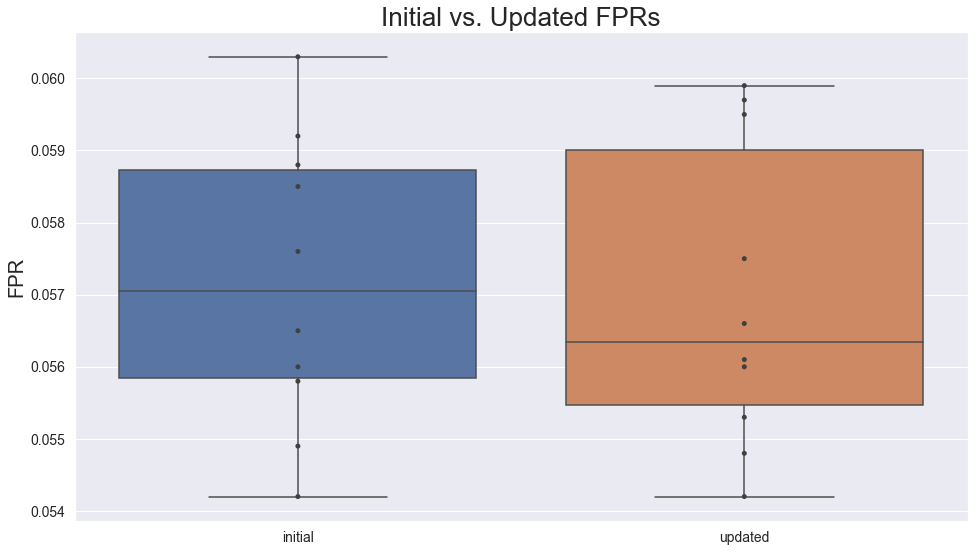

In [25]:
fprs = {"type": (["initial"] * len(initial_fprs)) + (["updated"] * len(updated_fprs)),
        "fpr": initial_fprs + updated_fprs}
data = pd.DataFrame(fprs)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="fpr", data=data, ax=ax)
sns.swarmplot(x="type", y="fpr", data=data, color=".25", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("FPR", size=20)
ax.set_title("Initial vs. Updated FPRs", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

### Logistic Regression

#### No Feedback

In [24]:
seeds = np.arange(10)
initial_fprs = []
updated_fprs = []

for seed in seeds:
    np.random.seed(seed)

    x_train, y_train = make_gaussian_data(m0, m1, s0, s1, n_train, p0, p1, features=n_features)

    x_update, y_update = make_gaussian_data(m0, m1, s0, s1, n_update, p0, p1, features=n_features)
    x_test, y_test = make_gaussian_data(m0, m1, s0, s1, n_test, p0, p1, features=n_features)
    
    model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
    
    new_model, _ = update_model_no_feedback(model, x_update, y_update, None, None, 1000)
    
    y_pred = new_model.predict(x_test)
    updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
    
    initial_fprs.append(initial_fpr)
    updated_fprs.append(updated_fpr)

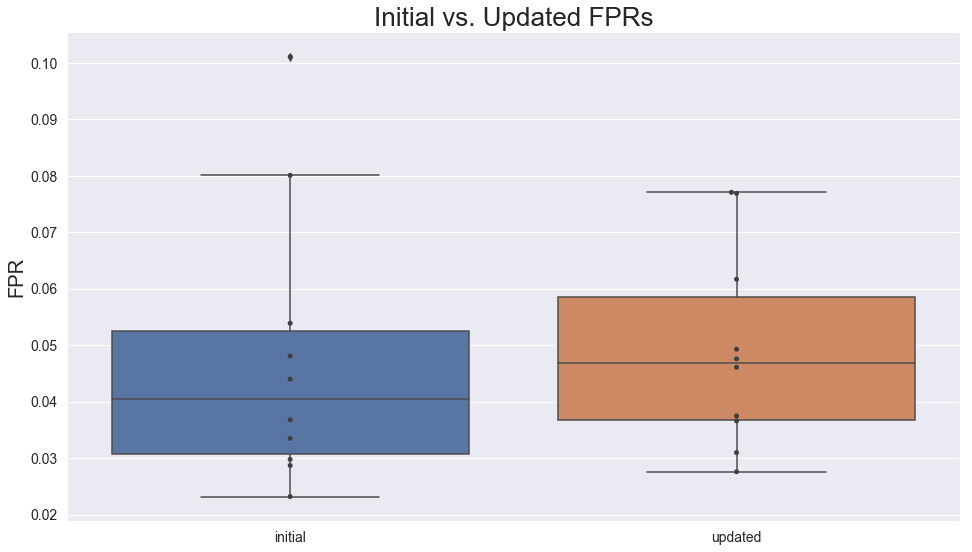

In [25]:
fprs = {"type": (["initial"] * len(initial_fprs)) + (["updated"] * len(updated_fprs)),
        "fpr": initial_fprs + updated_fprs}
data = pd.DataFrame(fprs)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="fpr", data=data, ax=ax)
sns.swarmplot(x="type", y="fpr", data=data, color=".25", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("FPR", size=20)
ax.set_title("Initial vs. Updated FPRs", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

#### Feedback

In [28]:
seeds = np.arange(10)
initial_fprs = []
updated_fprs = []

for seed in seeds:
    np.random.seed(seed)

    x_train, y_train = make_gaussian_data(m0 - 0.2, m1 - 0.1, s0, s1, n_train, p0, p1, features=n_features)

    x_update, y_update = make_gaussian_data(m0, m1, s0, s1, n_update, p0, p1, features=n_features)
    x_test, y_test = make_gaussian_data(m0, m1, s0, s1, n_test, p0, p1, features=n_features)
    
    model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
    
    new_model, _ = update_model_feedback(model, x_update, y_update, None, None, 1000)
    
    y_pred = new_model.predict(x_test)
    updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
    
    initial_fprs.append(initial_fpr)
    updated_fprs.append(updated_fpr)

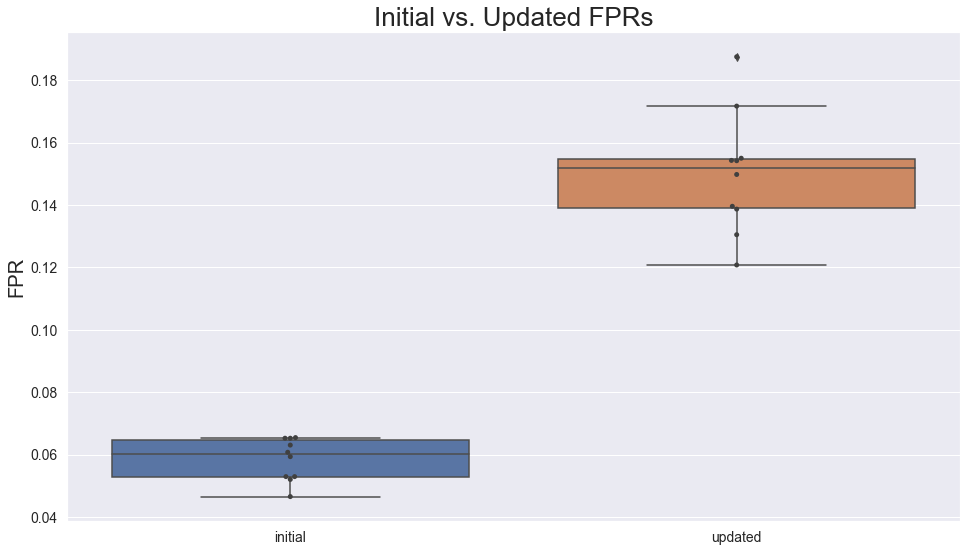

In [29]:
fprs = {"type": (["initial"] * len(initial_fprs)) + (["updated"] * len(updated_fprs)),
        "fpr": initial_fprs + updated_fprs}
data = pd.DataFrame(fprs)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="fpr", data=data, ax=ax)
sns.swarmplot(x="type", y="fpr", data=data, color=".25", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("FPR", size=20)
ax.set_title("Initial vs. Updated FPRs", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

### SVM

#### Linear Data

In [30]:
seeds = np.arange(10)
initial_fprs = []
updated_fprs = []

for seed in seeds:
    np.random.seed(seed)

    x_train, y_train = make_gaussian_data(m0 - 0.2, m1 - 0.1, s0, s1, n_train, p0, p1, features=n_features)

    x_update, y_update = make_gaussian_data(m0, m1, s0, s1, n_update, p0, p1, features=n_features)
    x_test, y_test = make_gaussian_data(m0, m1, s0, s1, n_test, p0, p1, features=n_features)
    
    model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="hinge")
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
    
    new_model, _ = update_model_feedback(model, x_update, y_update, None, None, 1000)
    
    y_pred = new_model.predict(x_test)
    updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
    
    initial_fprs.append(initial_fpr)
    updated_fprs.append(updated_fpr)

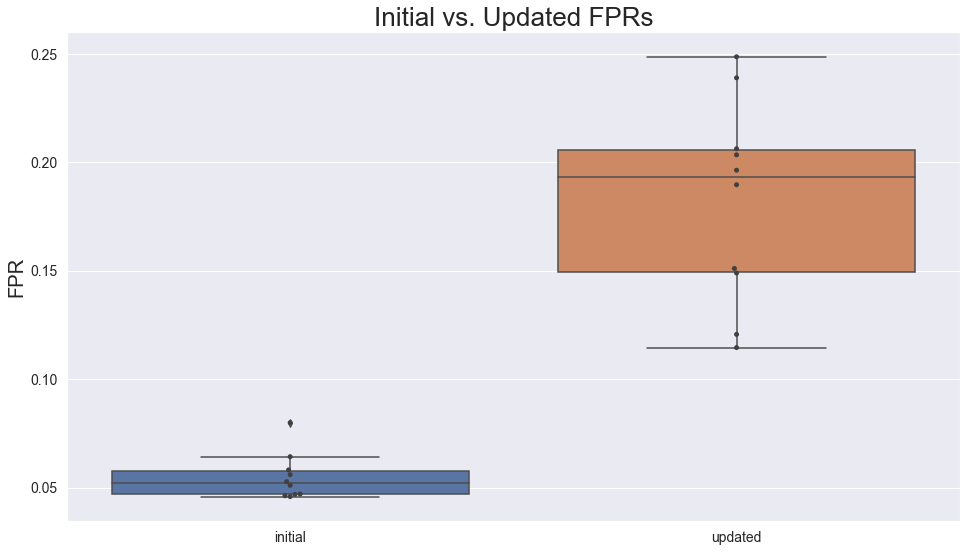

In [31]:
fprs = {"type": (["initial"] * len(initial_fprs)) + (["updated"] * len(updated_fprs)),
        "fpr": initial_fprs + updated_fprs}
data = pd.DataFrame(fprs)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="fpr", data=data, ax=ax)
sns.swarmplot(x="type", y="fpr", data=data, color=".25", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("FPR", size=20)
ax.set_title("Initial vs. Updated FPRs", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

#### Non Linear Data

In [16]:
seeds = np.arange(10)
initial_fprs = []
gold_standard_fprs = []
updated_fprs = []

n_train = 1000
n_update = 10000
n_test = 10000

for seed in seeds:
    print(seed)
    np.random.seed(seed)

    X1, y1 = make_gaussian_quantiles(cov=2.,
                                     n_samples=int((n_train + n_update + n_test) / 2), n_features=2,
                                     n_classes=2)
    X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                     n_samples=int((n_train + n_update + n_test) / 2), n_features=2,
                                     n_classes=2)
    x = np.concatenate((X1, X2))
    y = np.concatenate((y1, - y2 + 1))
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_update + n_test)
    x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)
    
    print(x_train.shape)
    
    base_model = svm.SVC(gamma="auto")
    base_model.fit(x_train, y_train)
    
    y_pred = base_model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
    
    gold_standard_model = svm.SVC(gamma="auto")
    gold_standard_model.fit(np.concatenate((x_train, x_update)), np.concatenate((y_train, y_update)))
    
    y_pred = gold_standard_model.predict(x_test)
    gold_standard_tnr, gold_standard_fpr, gold_standard_fnr, gold_standard_tpr = eval_model(y_test, y_pred)
    
    update_model = svm.SVC(gamma="auto")
    update_model.fit(x_train, y_train)
    new_model = update_model_full_fit(update_model, x_train, y_train, x_update, y_update, 50)
    
    y_pred = new_model.predict(x_test)
    updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
    
    initial_fprs.append(initial_fpr)
    gold_standard_fprs.append(gold_standard_fpr)
    updated_fprs.append(updated_fpr)



0
(1000, 2)
1
(1000, 2)
2
(1000, 2)
3
(1000, 2)
4
(1000, 2)
5
(1000, 2)
6
(1000, 2)
7
(1000, 2)
8
(1000, 2)
9
(1000, 2)


In [7]:
updated_fprs

[0.0504, 0.0226, 0.0279, 0.022, 0.0612, 0.0577, 0.0436, 0.0416, 0.062, 0.0191]

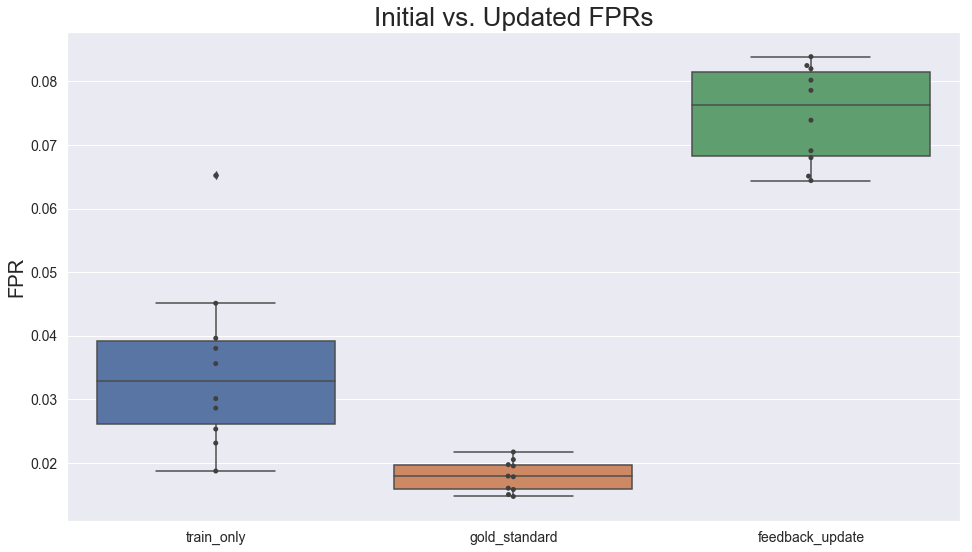

In [17]:
fprs = {"type": (["train_only"] * len(initial_fprs)) + (["gold_standard"] * len(gold_standard_fprs)) + (["feedback_update"] * len(updated_fprs)),
        "fpr": initial_fprs + gold_standard_fprs + updated_fprs}
data = pd.DataFrame(fprs)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="fpr", data=data, ax=ax)
sns.swarmplot(x="type", y="fpr", data=data, color=".25", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("FPR", size=20)
ax.set_title("Initial vs. Updated FPRs", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

In [45]:
gold_standard_fprs

[0.4631,
 0.4699,
 0.4576,
 0.4619,
 0.4575,
 0.4668,
 0.4681,
 0.4603,
 0.4562,
 0.4674]

In [9]:
gold_standard_fpr

0.4553

In [8]:
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=int((n_train + n_update + n_test) / 2), n_features=2,
                                 n_classes=2)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=int((n_train + n_update + n_test) / 2), n_features=2,
                                 n_classes=2)
x = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_update + n_test)
x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)

gold_standard_model = svm.SVC()
gold_standard_model.fit(np.concatenate((x_train, x_update)), np.concatenate((y_train, y_update)))

y_pred = gold_standard_model.predict(x_test)
gold_standard_tnr, gold_standard_fpr, gold_standard_fnr, gold_standard_fpr = eval_model(y_test, y_pred)


/h/alexadam/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Random Forests